In [3]:
import sys
sys.path.append("../..")
import torch
from pathlib import Path
import scipy
import numpy as np
from lru.architectures import DLRU, DLRUConfig
from lru.reduction import lru_reduction_pipeline
import matplotlib.pyplot as plt
import torchid.metrics  # pip install pytorch-ident
import copy
from plot_utils import set_size, tex_fonts, LINEWIDTH_L_CSS as linewidth

In [4]:
plt.rcParams.update(tex_fonts) # use latex fonts
plt.rcParams.update({"axes.grid": True}) 

In [5]:
# Load data
data_folder = ("F16GVT_Files", "BenchmarkData")

# file_name = "F16Data_SineSw_Level5.mat"
#
# file_name = "F16Data_FullMSine_Level7.mat"
# file_name = "F16Data_FullMSine_Level5.mat"
#file_name = "F16Data_FullMSine_Level2_Validation.mat"
#file_name = "F16Data_FullMSine_Level4_Validation.mat"
file_name = "F16Data_FullMSine_Level6_Validation.mat"
# file_name = "F16Data_SineSw_Level6_Validation.mat"
file_path = Path(*data_folder) / file_name
data = scipy.io.loadmat(file_path)

In [6]:
#run = "ckpt_large_no_reg"
run = "ckpt_large_reg_modal"  # lasso on eigs abs val
#run = "ckpt_large_reg_hankel"
#run = "ckpt_large_reg_hankel_cc"


In [7]:
fig_folder = Path("fig")
fig_folder.mkdir(exist_ok=True)

In [8]:
reduce = False
modes = 20 # modes to be kept
#reduction_method = "modal_singular_perturbation" # modal | balanced_truncation | balanced_truncation_cc
#reduction_method = "balanced_singular_perturbation"
reduction_method = "modal_singular_perturbation"
#reduction_method = "balanced_truncation"

In [9]:
ckpt = torch.load(Path("ckpt")/ f"{run}.pt", map_location="cpu")
cfg = ckpt["cfg"]
scaler_u = ckpt["scaler_u"]
scaler_y = ckpt["scaler_y"]

/Users/marco.forgione/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
u_test = data["Force"].T  # Or force
y_test = data["Acceleration"].T

In [11]:
# Load model
config = DLRUConfig(
    d_model=cfg.d_model, d_state=cfg.d_state, n_layers=cfg.n_layers, ff=cfg.ff
)
model = DLRU(1, 3, config)
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [12]:
fgw, fgh = set_size(2*linewidth, fraction=1.0)

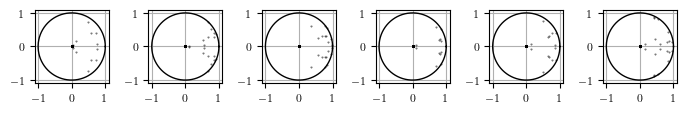

In [13]:

fig, ax = plt.subplots(1, config.n_layers, figsize=(fgw, fgw*0.2))
#fig, ax = plt.subplots(1, config.n_layers, figsize=set_size(linewidth, fraction=1.0))
#fig, ax = plt.subplots(1, config.n_layers, figsize=(3 * config.n_layers, 3.0), sharex=True)#, sharey=True)
t = np.linspace(0, 2 * np.pi, 1000)
#plt.suptitle("Complex eigenvalues")
for idx, layer in enumerate(model.blocks):  # range(config.n_layers):
    lambdas, *_ = layer.lru.ss_params()
    lambdas = lambdas.detach()
    ax[idx].plot(np.cos(t), np.sin(t), "-k", linewidth=0.99)
    ax[idx].plot(lambdas.real, lambdas.imag, "k*", markersize=0.99, alpha=0.4)  # lambdas.real
    ax[idx].plot(lambdas.real, -lambdas.imag, "k*", markersize=0.99, alpha=0.4)  # lambdas.real
    ax[idx].set_box_aspect(1)
plt.tight_layout()
plt.savefig(fig_folder / f"{run}_eigs_complex.pdf")

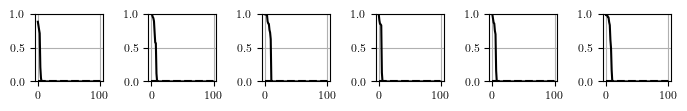

In [14]:
fig, ax = plt.subplots(1, config.n_layers, figsize=(fgw, fgw*0.2))
#plt.suptitle("Eigenvalues absolute value")
t = np.linspace(0, 2 * np.pi, 1000)
for idx, layer in enumerate(model.blocks):  # range(config.n_layers):
    lambdas, *_ = layer.lru.ss_params()
    lambdas = lambdas.detach().numpy()
    ax[idx].plot(np.sort(np.abs(lambdas))[::-1], "k-")  # lambdas.real
    ax[idx].set_ylim([0, 1])
    ax[idx].set_box_aspect(1)
    ax[idx].plot(np.zeros(lambdas.shape), "k--")
plt.tight_layout()
plt.savefig(fig_folder / f"{run}_eigs_abs.pdf")

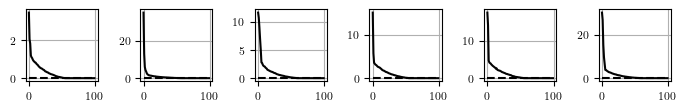

In [15]:
#model = model.double()
fig, ax = plt.subplots(1, config.n_layers, figsize=(fgw, fgw*0.2))
#fig, ax = plt.subplots(1, config.n_layers, figsize=(3 * config.n_layers, 3.0), sharex=True)#, sharey=True)
#plt.suptitle("Hankel values")
t = np.linspace(0, 2 * np.pi, 1000)
for idx, layer in enumerate(model.blocks):  # range(config.n_layers):
    #hankel = layer.lru.hankel_singular_values_double(cc=cc_reduction)
    hankel = layer.lru.hankel_singular_values(cc=True if reduction_method=="balanced_truncation_cc" else False)
    hankel = hankel.detach().numpy()
    ax[idx].plot(hankel, "k", alpha=0.99)
    ax[idx].plot(np.zeros(hankel.shape), "k--")
    ax[idx].set_box_aspect(1) 
#ax[0].set_ylim([0, 0.1])
#ax[0].set_xlim([0, 20])
plt.tight_layout()
plt.savefig(fig_folder / f"{run}_hankel.pdf")

In [16]:
model_reduced = copy.deepcopy(model)

if reduce:
    for block in model_reduced.blocks:

        # reduction pipeline
        ss_params = block.lru.ss_params()
        ss_params = [param.detach().numpy() for param in ss_params]
        lambdas, B, C, D = ss_params
        lambdas_red, B_red, C_red, D_red = lru_reduction_pipeline(lambdas, B, C, D,  modes=modes, method=reduction_method)


        params_red = [lambdas_red.astype(np.complex64), B_red.astype(np.complex64), C_red.astype(np.complex64), D_red.astype(np.float32)]
        params_red = [torch.tensor(param_red) for param_red in params_red]
        block.lru.replace_ss_params(*params_red)

In [17]:
model_reduced.blocks[5].lru.nu_log.shape, model.blocks[0].lru.nu_log.shape

(torch.Size([100]), torch.Size([100]))

In [18]:
params = sum(map(torch.numel, model.parameters()))
params_red = sum(map(torch.numel, model_reduced.parameters()))
reduction = 100 * (1 - params_red / params)
print(f"{params} original paramers...\n{params_red} original paramers\n{reduction}% parameter reduction")

199153 original paramers...
199153 original paramers
0.0% parameter reduction


In [19]:
ut = torch.tensor(scaler_u.transform(u_test)).unsqueeze(0).float()
with torch.no_grad():
    #    y_test_hat = model(ut, mode="scan").squeeze(0).to("cpu").numpy()
    y_test_hat = model_reduced(ut, mode="scan").squeeze(0).to("cpu").numpy()

y_test_hat = scaler_y.inverse_transform(y_test_hat)

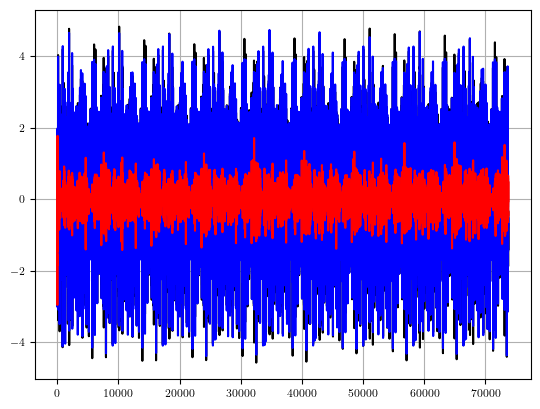

In [20]:
plt.figure()
plt.plot(y_test[:, 0], "k")
plt.plot(y_test_hat[:, 0], "b")
plt.plot(y_test_hat[:, 0] - y_test[:, 0], "r")

In [21]:
fit = torchid.metrics.fit_index(y_test, y_test_hat)
rmse = torchid.metrics.rmse(y_test, y_test_hat) * 100
nrmse = torchid.metrics.nrmse(y_test, y_test_hat) * 100

np.set_printoptions(precision=1)
print(f"{fit=} \n{rmse=} \n{nrmse=}")

fit=array([85.5, 89.8, 74.5]) 
rmse=array([19.5, 17.1, 39.5]) 
nrmse=array([14.5, 10.2, 25.5])


Results on "F16Data_FullMSine_Level6_Validation.mat", no MOR

no_reg:

fit=array([86.55459738, 90.08863281, 76.25738613])

rmse=array([18.00991169, 16.72490559, 36.77659407])

nrmse=array([0.13445403, 0.09911367, 0.23742614])


reg_modal:

fit=array([85.47068315, 89.83750936, 74.46776937]) 

rmse=array([19.46179826, 17.14866306, 39.54865656]) 

nrmse=array([0.14529317, 0.10162491, 0.25532231])


reg_hankel:

fit=array([85.80137479, 89.02136512, 75.51860243]) 

rmse=array([19.01884186, 18.52586312, 37.92094778]) 

nrmse=array([0.14198625, 0.10978635, 0.24481398])



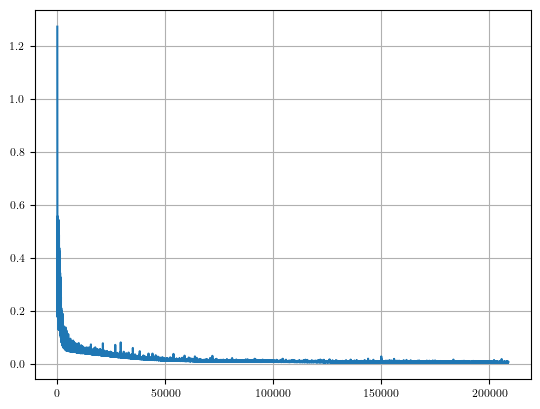

In [22]:
plt.figure()
plt.plot(ckpt["LOSS"])
#plt.ylim([0.0, 0.2])